based on 

https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from custom_tensorboard import TrainValTensorBoard

Using TensorFlow backend.


In [47]:
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [4]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [5]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [6]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [7]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    #trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix)
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [8]:
train_x, train_y, test_x, test_y = load_dataset('../data/HAR/UCI_HAR_Dataset/')

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [9]:
train_x.shape

(7352, 128, 9)

In [10]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

keras imports

In [11]:
from keras import Model
from keras.layers import Lambda, Input, Dropout, Flatten, LSTM, Concatenate
from keras import backend as K
from keras.callbacks import TensorBoard
from time import time
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from time import time

## Model generators

In [12]:
def dense_model_generator(n_timesteps, n_features, provided_input = None):

    #Input
    if provided_input == None:
        x = Input((n_timesteps, n_features))
    else:
        x = provided_input
        
    #Dense
    dense_1 = Lambda(lambda x: K.tf.unstack(x, axis=2))(x)
    dense_2 = [Dense(20)(x) for x in dense_1]
    dense_3 = Lambda(lambda x: K.stack(x, axis=2))(dense_2)
    dense_4 = Dropout(0.1)(dense_3)
    dense_5 = Flatten()(dense_4)
    dense_6 = Dense(250, activation = 'relu')(dense_5)
    dense_7 = Dense(20, activation = 'relu')(dense_6)
    dense_8 = Dense(n_outputs, activation='softmax')(dense_7)
    
    return x, dense_8, dense_6


def lstm_model_generator(n_timesteps, n_features, provided_input = None):
    
    #Input
    if provided_input == None:
        x = Input((n_timesteps, n_features))
    else:
        x = provided_input

    #LSTM
    lstm_1 = LSTM(100, input_shape=(n_timesteps,n_features))(x)
    lstm_2 = Dropout(0.5)(lstm_1)
    lstm_3 = Dense(100, activation='relu')(lstm_2)
    lstm_4 = Dense(n_outputs, activation='softmax', name='lstm_out')(lstm_3)
    
    return x, lstm_4, lstm_3


def hybrid_ens_generator(n_timesteps, n_features):

    dense_in, dense_out, dense_int = dense_model_generator(n_timesteps, n_features)
    lstm_in, lstm_out, lstm_int  = lstm_model_generator(n_timesteps, n_features, provided_input=dense_in)

    ens_1 = Concatenate(axis=1)([lstm_int,dense_int])
    ens_2 = Dense(n_outputs, activation='softmax')(ens_1)
    
    return dense_in, ens_2, ens_1

https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

In [13]:
import tensorflow as tf 

def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

auc_roc = as_keras_metric(tf.metrics.auc)
recall = as_keras_metric(tf.metrics.recall)


https://stackoverflow.com/questions/50874596/how-to-detect-the-epoch-where-keras-earlystopping-occurred

In [14]:
#lr_cb = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_delta = 0.01, patience = 3, verbose = 1)
#es_cb = EarlyStopping(monitor = 'val_loss', min_delta=0.01, patience = 10, verbose = 1, restore_best_weights = True)

min_delta_val = 0.02

lr_cb = ReduceLROnPlateau(monitor = 'val_auc', mode='max', 
                          factor = 0.5, min_delta = min_delta_val, patience = 3, verbose = 1)
es_cb = EarlyStopping(monitor = 'val_auc', mode='max', 
                      min_delta=min_delta_val, patience = 10, verbose = 1, restore_best_weights = True)

callbacks = [lr_cb, es_cb]

Training parameters

In [55]:
N_train = 4
adam = optimizers.adam(lr=0.01)
validation_split_on_training = 0.2
epochs = 100
batch_size = 100

In [56]:
def generate_trained_models(model_type):
    
    print_summary_only_once = True
    trained_models = []
    trained_models_best_epoch = []
    trained_models_stats = []
    trained_models_time_taken = []

    model_name_base = model_type
    
    if model_type =='dense':
        model_generator = dense_model_generator
    elif model_type =='LSTM':
        model_generator = lstm_model_generator
    elif model_type =='ens':
        model_generator = hybrid_ens_generator
    else:
        raise ValueError('No model type found')

            
        
    for i in range(N_train):
        tic = time()
        model_name = model_name_base + '_' + str(i)
        tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
        callbacks_model = callbacks + [tensorboard]

        # generate model
        model_input, model_output , _ = model_generator(n_timesteps, n_features)
        model = Model(model_input, model_output, name = model_name)

        #compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc, recall])
        if print_summary_only_once:
            model.summary()
            print_summary_only_once = False

        # train model
        model.fit(train_x, 
                  train_y, epochs=epochs, 
                  batch_size=batch_size, 
                  validation_split=validation_split_on_training,
                  verbose=True,
                  callbacks = callbacks_model)     
        trained_models.append(model)

        # training time
        training_time = time()-tic
        trained_models_time_taken.append(training_time)
        print('training time: {}s'.format(training_time))

        # early stopping epoch
        best_epoch = es_cb.stopped_epoch
        trained_models_best_epoch.append(best_epoch)

        #append best stat
        best_stats = {}
        for key in model.history.history.keys():
            best_stats[key] = model.history.history[key][best_epoch]
        trained_models_stats.append(best_stats)
    
    trained_models_stats = pd.DataFrame(trained_models_stats)
    return trained_models, trained_models_stats, trained_models_time_taken, trained_models_best_epoch

In [57]:
model_types = ['dense', 'LSTM', 'ens']
trainig_reulsts = {}

for model_name in model_types:
    
    trained_models, trained_models_stats, trained_models_time_taken, trained_models_best_epoch = generate_trained_models(model_name)
    stats_best_epoch = pd.DataFrame(trained_models_best_epoch, columns=['epoch']).mean()
    stats_time_takes = pd.DataFrame(trained_models_time_taken, columns=['time']).mean()
    stats_best_stats = pd.DataFrame(trained_models_stats).mean()

    trainig_reulsts[model_name] = {'trained_models': trained_models,
                                  'trained_models_stats': trained_models_stats,
                                  'trained_models_time_taken': trained_models_time_taken,
                                  'trained_models_best_epoch': trained_models_best_epoch,
                                  'stats_best_epoch': stats_best_epoch,
                                  'stats_time_takes': stats_time_takes,
                                  'stats_best_stats': stats_best_stats}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 128, 9)       0                                            
__________________________________________________________________________________________________
lambda_23 (Lambda)              [(None, 128), (None, 0           input_12[0][0]                   
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 20)           2580        lambda_23[0][0]                  
__________________________________________________________________________________________________
dense_134 (Dense)               (None, 20)           2580        lambda_23[0][1]                  
__________________________________________________________________________________________________
dense_135 

5881/5881 [==============================] - 1s 109us/step - loss: 0.4438 - acc: 0.8512 - auc: 0.9331 - recall: 1.0000 - val_loss: 0.5260 - val_acc: 0.8443 - val_auc: 0.9509 - val_recall: 1.0000
Epoch 3/100
5881/5881 [==============================] - 1s 108us/step - loss: 0.2575 - acc: 0.9063 - auc: 0.9607 - recall: 1.0000 - val_loss: 0.4784 - val_acc: 0.8600 - val_auc: 0.9677 - val_recall: 1.0000
Epoch 4/100
5881/5881 [==============================] - 1s 106us/step - loss: 0.1881 - acc: 0.9303 - auc: 0.9723 - recall: 1.0000 - val_loss: 0.4594 - val_acc: 0.8736 - val_auc: 0.9758 - val_recall: 1.0000
Epoch 5/100
5881/5881 [==============================] - 1s 110us/step - loss: 0.1489 - acc: 0.9435 - auc: 0.9784 - recall: 1.0000 - val_loss: 0.4803 - val_acc: 0.8776 - val_auc: 0.9804 - val_recall: 1.0000
Epoch 6/100
5881/5881 [==============================] - 1s 107us/step - loss: 0.1258 - acc: 0.9495 - auc: 0.9820 - recall: 1.0000 - val_loss: 0.5708 - val_acc: 0.8838 - val_auc: 0.983

5881/5881 [==============================] - 1s 113us/step - loss: 0.0999 - acc: 0.9573 - auc: 0.9879 - recall: 1.0000 - val_loss: 0.4550 - val_acc: 0.9048 - val_auc: 0.9883 - val_recall: 1.0000
Epoch 9/100
5881/5881 [==============================] - 1s 98us/step - loss: 0.0945 - acc: 0.9600 - auc: 0.9887 - recall: 1.0000 - val_loss: 0.4612 - val_acc: 0.9055 - val_auc: 0.9890 - val_recall: 1.0000
Epoch 10/100
5881/5881 [==============================] - 1s 100us/step - loss: 0.0896 - acc: 0.9607 - auc: 0.9894 - recall: 1.0000 - val_loss: 0.4691 - val_acc: 0.9028 - val_auc: 0.9896 - val_recall: 1.0000

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11/100
5881/5881 [==============================] - 1s 98us/step - loss: 0.0863 - acc: 0.9626 - auc: 0.9898 - recall: 1.0000 - val_loss: 0.4613 - val_acc: 0.9055 - val_auc: 0.9900 - val_recall: 1.0000
Epoch 12/100
5881/5881 [==============================] - 1s 90us/step - loss: 0.0862 - acc: 0.9624 - a

5881/5881 [==============================] - 9s 2ms/step - loss: 0.2725 - acc: 0.9007 - auc: 0.9561 - recall: 1.0000 - val_loss: 0.4860 - val_acc: 0.8797 - val_auc: 0.9583 - val_recall: 1.0000
Epoch 11/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.2099 - acc: 0.9277 - auc: 0.9606 - recall: 1.0000 - val_loss: 0.4411 - val_acc: 0.9007 - val_auc: 0.9627 - val_recall: 1.0000
Epoch 12/100
5881/5881 [==============================] - 8s 1ms/step - loss: 0.1648 - acc: 0.9434 - auc: 0.9646 - recall: 1.0000 - val_loss: 0.4371 - val_acc: 0.8946 - val_auc: 0.9664 - val_recall: 1.0000
Epoch 13/100
5881/5881 [==============================] - 9s 1ms/step - loss: 0.1479 - acc: 0.9493 - auc: 0.9681 - recall: 1.0000 - val_loss: 0.4243 - val_acc: 0.8919 - val_auc: 0.9696 - val_recall: 1.0000

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14/100
5881/5881 [==============================] - 9s 1ms/step - loss: 0.1387 - acc: 0.9485 - auc: 0.

5881/5881 [==============================] - 9s 1ms/step - loss: 0.1079 - acc: 0.9609 - auc: 0.9796 - recall: 1.0000 - val_loss: 0.4405 - val_acc: 0.9001 - val_auc: 0.9802 - val_recall: 1.0000
Epoch 19/100
5881/5881 [==============================] - 9s 1ms/step - loss: 0.3709 - acc: 0.8813 - auc: 0.9804 - recall: 1.0000 - val_loss: 0.5583 - val_acc: 0.8090 - val_auc: 0.9803 - val_recall: 1.0000

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 20/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.2963 - acc: 0.8725 - auc: 0.9804 - recall: 1.0000 - val_loss: 0.5018 - val_acc: 0.8314 - val_auc: 0.9806 - val_recall: 1.0000
Epoch 21/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.2619 - acc: 0.8854 - auc: 0.9808 - recall: 1.0000 - val_loss: 0.4890 - val_acc: 0.8470 - val_auc: 0.9810 - val_recall: 1.0000
Epoch 22/100
5881/5881 [==============================] - 9s 1ms/step - loss: 0.2487 - acc: 0.8915 - auc: 0.

Train on 5881 samples, validate on 1471 samples
Epoch 1/100
5881/5881 [==============================] - 11s 2ms/step - loss: 0.9183 - acc: 0.6626 - auc: 0.8413 - recall: 0.9830 - val_loss: 0.7372 - val_acc: 0.8015 - val_auc: 0.9254 - val_recall: 1.0000
Epoch 2/100
5881/5881 [==============================] - 8s 1ms/step - loss: 0.4247 - acc: 0.8592 - auc: 0.9461 - recall: 1.0000 - val_loss: 0.5257 - val_acc: 0.8545 - val_auc: 0.9585 - val_recall: 1.0000
Epoch 3/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.2571 - acc: 0.9116 - auc: 0.9662 - recall: 1.0000 - val_loss: 0.4995 - val_acc: 0.8647 - val_auc: 0.9714 - val_recall: 1.0000
Epoch 4/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.2065 - acc: 0.9250 - auc: 0.9749 - recall: 1.0000 - val_loss: 0.4362 - val_acc: 0.8742 - val_auc: 0.9777 - val_recall: 1.0000
Epoch 5/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.1552 - acc: 0.9424 - auc: 0.9800 - recall: 1.0000 - 

Epoch 7/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.1198 - acc: 0.9522 - auc: 0.9840 - recall: 1.0000 - val_loss: 0.4872 - val_acc: 0.8933 - val_auc: 0.9848 - val_recall: 1.0000

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.1055 - acc: 0.9585 - auc: 0.9856 - recall: 1.0000 - val_loss: 0.4640 - val_acc: 0.9048 - val_auc: 0.9863 - val_recall: 1.0000
Epoch 9/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.1013 - acc: 0.9587 - auc: 0.9869 - recall: 1.0000 - val_loss: 0.4694 - val_acc: 0.9035 - val_auc: 0.9873 - val_recall: 1.0000
Epoch 10/100
5881/5881 [==============================] - 9s 2ms/step - loss: 0.0954 - acc: 0.9611 - auc: 0.9878 - recall: 1.0000 - val_loss: 0.4805 - val_acc: 0.9041 - val_auc: 0.9881 - val_recall: 1.0000

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11/100
5881

_____
model: dense 

mean best epoc: [13.25]
mean training time: [19.81798023]
STATS:
acc           0.963909
auc           0.990192
loss          0.080444
lr            0.000125
recall        1.000000
val_acc       0.896499
val_auc       0.990291
val_loss      0.549082
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


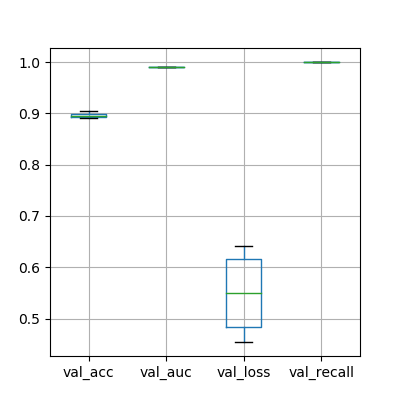

_____
model: LSTM 

mean best epoc: [22.25]
mean training time: [218.90650195]
STATS:
acc           0.879315
auc           0.966488
loss          0.304204
lr            0.000059
recall        1.000000
val_acc       0.841774
val_auc       0.966834
val_loss      0.616643
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


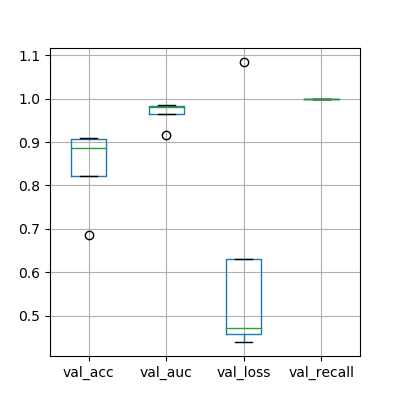

_____
model: ens 

mean best epoc: [13.5]
mean training time: [151.04315102]
STATS:
acc           0.963102
auc           0.989993
loss          0.084793
lr            0.000125
recall        1.000000
val_acc       0.903297
val_auc       0.990087
val_loss      0.504837
val_recall    1.000000
dtype: float64




<IPython.core.display.Javascript object>


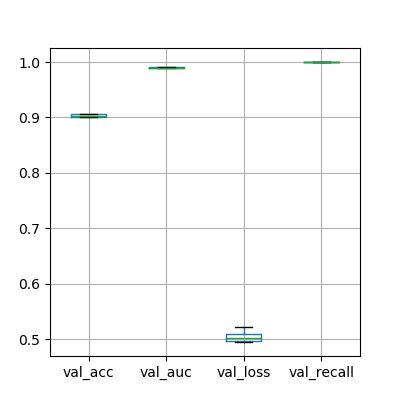

In [58]:
for model_name in trainig_reulsts.keys():
    print('_____')
    print('model: {} \n'.format(model_name))
    print('mean best epoc: {}'.format(trainig_reulsts[model_name]['stats_best_epoch'].values))
    print('mean training time: {}'.format(trainig_reulsts[model_name]['stats_time_takes'].values))
    
    print('STATS:')
    
    print(trainig_reulsts[model_name]['stats_best_stats'])
    print('\n')

    plt.figure(figsize = (4,4))
    stats_for_model = trainig_reulsts[model_name]['trained_models_stats']
    stats_for_model[stats_for_model.columns[stats_for_model.columns.str.contains(pat = 'val')]].boxplot()
    

In [74]:
stats_for_model[['val_auc']].values.ravel()

array([0.99046798, 0.98990205, 0.9897956 , 0.99018248])

In [90]:
trainig_reulsts[model_name][which]['val_auc']


0    0.990477
1    0.989573
2    0.990288
3    0.990828
Name: val_auc, dtype: float64

In [95]:
plot_metrics

[0    0.990477
 1    0.989573
 2    0.990288
 3    0.990828
 Name: val_auc, dtype: float64, 0    0.917288
 1    0.986284
 2    0.982706
 3    0.981059
 Name: val_auc, dtype: float64, 0    0.990468
 1    0.989902
 2    0.989796
 3    0.990182
 Name: val_auc, dtype: float64]

<IPython.core.display.Javascript object>


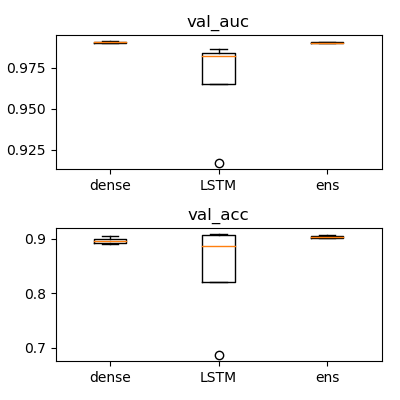

In [98]:
plt.figure(figsize = (4,4))
model_names = trainig_reulsts.keys()
metric = 'val_auc'
for i, metric in enumerate(['val_auc', 'val_acc']):
    plt.subplot(2,1,i+1)
    plt.title(metric)
    which = 'trained_models_stats'
    plot_metrics = [trainig_reulsts[model_name][which][metric] for model_name in model_names]
    plt.boxplot(plot_metrics, labels= model_names)
    plt.tight_layout()    

In [ ]:
model_name = 'dense'
trained_models = []

print_summary_only_once = True
best_model_epoch = []
trained_models_stats = []
trained_models_time_taken = []


for i in range(N_train):
    tic = time()
    model_name = model_name + '_' + str(i)
    tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
    callbacks_model = callbacks + [tensorboard]

    # generate model
    model_input, model_output , _ = dense_model_generator(n_timesteps, n_features)
    model = Model(model_input, model_output, name = model_name)
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc, recall])
    if print_summary_only_once:
        model.summary()
        print_summary_only_once = False
    
    # train model
    model.fit(train_x, 
              train_y, epochs=epochs, 
              batch_size=batch_size, 
              validation_split=validation_split_on_training,
              verbose=True,
              callbacks = callbacks_model)     
    trained_models.append(model)
    
    # training time
    training_time = time()-tic
    trained_models_time_taken.append(training_time)
    print('training time: {}s'.format(training_time))
    
    # early stopping epoch
    best_epoch = es_cb.stopped_epoch
    best_model_epoch.append(best_epoch)
    
    #append best stat
    best_stats = {}
    for key in model.history.history.keys():
        best_stats[key] = model.history.history[key][best_epoch]
    trained_models_stats.append(best_stats)

In [ ]:
model_name = 'dense'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_dense = callbacks + [tensorboard]

#generate model
dense_input, dense_output , _ = dense_model_generator(n_timesteps, n_features)
model = Model(dense_input, dense_output, name = model_name)

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(train_x, 
          train_y, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_dense)

In [ ]:
model_name = 'LSTM'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_lstm = callbacks + [tensorboard]

lstm_input, lstm_output, _  = lstm_model_generator(n_timesteps, n_features)

model = Model(lstm_input, lstm_output, name= model_name )
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_x, 
          train_y, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_lstm)


### Dense network approach

some comments about this architecture:

- Note that the unstack dim is the feature dimension

In [ ]:
model_name = 'dense'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_dense = callbacks + [tensorboard]

#generate model
dense_input, dense_output , _ = dense_model_generator(n_timesteps, n_features)
model = Model(dense_input, dense_output, name = model_name)

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(train_x, 
          train_y, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_dense)

# Hybrid ensemble

In [ ]:
model_name = 'ens'
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name + '_' + str(time())))
callbacks_ens = callbacks + [tensorboard]

ens_input, ens_output, _  = hibrid_ens_generator(n_timesteps, n_features)


model = Model(ens_input, ens_output, name= model_name)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(train_x, 
          train_y, epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split_on_training,
          verbose=True,
         callbacks = callbacks_ens)

